In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft, fftfreq
from scipy.io import loadmat
import xlsxwriter 
%matplotlib inline
import import_ipynb
import functions_NGD
import random

importing Jupyter notebook from functions_NGD.ipynb


## Load data / find cross-correlation of ganglion cell output

importing Jupyter notebook from NGDfunc.ipynb


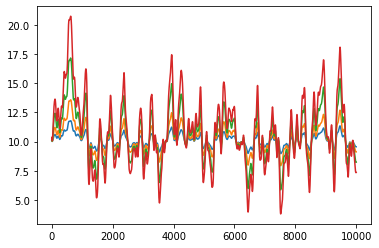

In [2]:
import os
os.chdir('F:/我的雲端硬碟/Retina exp/python code/functions')
import import_ipynb
import NGDfunc

dt=0.01
tau_ou=1
fc=1
T_ou=100
nsteps_ou=int(T_ou/dt)
mid_pos=500
randseed = np.random.normal(0, 50, nsteps_ou)
time_ou,x_ou=NGDfunc.OU(T_ou,tau_ou,'no',dt,randseed)
time_ou,x_lpou=NGDfunc.OU(T_ou,tau_ou,fc,dt,randseed)

amp=[0.5,1,2,3]
mean=10
x_set=[]
# x_set.append(x_lpou/np.std(x_lpou)*amp[3]+20)
for i in range(len(amp)):
    x_set.append(x_lpou/np.std(x_lpou)*amp[i]+mean)
    plt.plot(x_set[i])


## NGD output

In [3]:
alpha,beta,K,g=6,1.6,22,10 # channel 39
# alpha,beta,K,g=8,1.4,37,10 # channel 47
y_set=[functions_NGD.NGD(x_set[j],dt,alpha,beta,K,g,1)[0] for j in range(np.size(x_set,0))] 
z_set=[functions_NGD.NGD(x_set[j],dt,alpha,beta,K,g,1)[1] for j in range(np.size(x_set,0))] 

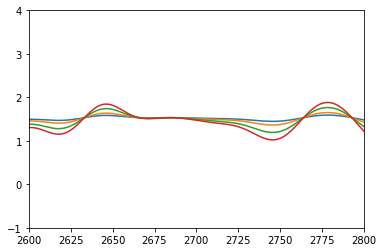

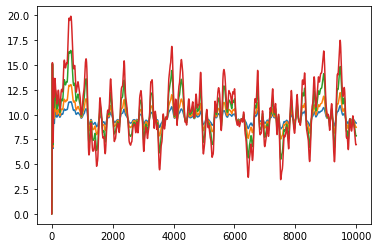

In [4]:
for i in range(4):
    plt.plot(y_set[i])
plt.ylim(-1,4)
plt.xlim(2600,2800)
plt.show()
for i in range(4):
    plt.plot(z_set[i])
# plt.ylim(-1,4)
# plt.xlim(2000,4000)

## Adding horizontal feedback to NGD output (y+z)

### MI and cross correlation of B

[0.8 0.9]


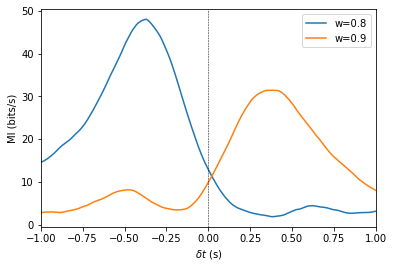

In [5]:
# wy=np.linspace(0.8,1,5)
wy=np.array([0.8,0.9])
# wy=0.9
print(wy)
# wy=[]
iamp=3
x=x_set[iamp]
y=y_set[iamp]
z=z_set[iamp]
B=[wy[k]*y-(1-wy[k])*z for k in range(len(wy))]
MIxyz=[[] for i in range(len(B))]
corrxyz=[[] for i in range(len(B))]
for k in range(len(B)):
    tsxyz,MIxyz[k]=functions_NGD.MI(functions_NGD.EqualState(x,8),functions_NGD.EqualState(B[k],8),dt,[-2,2])
    tc,corrxyz[k]=functions_NGD.xcorr_quick(x,B[k],5,0.01)
# color2=['k','r']
for i in range(len(B)):
    plt.plot(tsxyz,MIxyz[i],label='w='+str(round(wy[i],3)))
plt.legend()
plt.xlim(-1,1)
plt.ylabel('MI (bits/s)')
plt.xlabel('$\delta t$ (s)')
plt.axvline(x=0,c='k',linewidth=0.5,linestyle='dashed')
# plt.grid()
# find prediction horizon

# for i in range(len(MIxyz)):
#     plt.plot(tsxyz[np.argmax(MIxyz[i])],max(MIxyz[i]),'o')
# plt.show()

# plt.savefig('F:/我的雲端硬碟/Retina exp/Poster present/Sfn poster 20210111/figure/MI_fb_ff.png',dpi=300)

# for i in range(len(B)):
#     plt.plot(tc,corrxyz[i])
# plt.xlim(-5,5)
# plt.grid()

### adding a HC-BC gain 

### generate poisson spikes

In [6]:
# poisson as a function
def poisson(r_in,thr):
    rtemp=r_in-thr
    rtemp[rtemp>0]=0
    rtemp=rtemp/np.mean(rtemp)*5 # let the mean firing rate as 5 hz
    tempspikes=np.zeros(len(rtemp))
    for step in range(len(rtemp)):
        if random.random()<rtemp[step]*dt:
            tempspikes[step]=1
        else:
            tempspikes[step]=0
    return tempspikes

In [7]:
thr=0.6
SpikeTrains_Poisson=[[] for i in range(len(B))]
for i in range(len(B)):
    rtemp=B[i]-thr
    rtemp[rtemp>0]=0
    rtemp=rtemp/np.mean(rtemp)*5 # let the mean firing rate as 5 hz
    tempspikes=np.zeros(len(rtemp))
    for step in range(len(rtemp)):
        if random.random()<rtemp[step]*dt:
            tempspikes[step]=1
        else:
            tempspikes[step]=0
    SpikeTrains_Poisson[i]=tempspikes

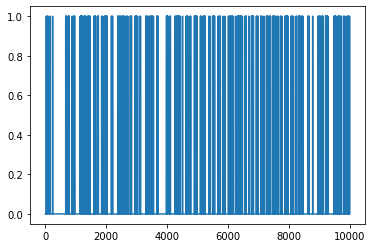

In [8]:
plt.plot(SpikeTrains_Poisson[1])
# plt.xlim(10000,10500)

In [9]:
print(np.size(SpikeTrains_Poisson,0))

2


In [26]:
# Generater Spike time train using Poisson
# Refering "Poisson Model of Spike Generation" by Heeger (2000); https://www.cns.nyu.edu/~david/handouts/poisson.pdf.
def Spike_Time_Generater(rdt, dt, r_mean, Gamma=1):  
    # rdt: original input (continuous)
    # dt: time bin length of the imput
    # r_mean: target mean firing rate
    # Gamma: Gamma tune the spike interval (without changing the probability of spike count);
    #        First increase the target firing rate by Gamma, then only expert every Gamma-th spike.
    rdt = rdt /(sum(rdt)/ (len(rdt)*dt) ) *r_mean          *Gamma
          #original mean firing rate
    Spike_time = []
    
    timeBinCounter = 0 # time bin index
    p = 1 # probability of no spike in a bin.

    while True:

        # Use a random number to determine if there is a spike in the bin; if not, accumalate the probability of not firing (lowering "p"). 
        # The while loop stops when a spike appears.
        theRandomNumber = 1-np.random.rand()
        while (theRandomNumber < p and timeBinCounter < len(rdt)): 
            p *= np.exp(-rdt[timeBinCounter]) 
            timeBinCounter += 1
        if timeBinCounter >= len(rdt): # End the funciton when current time exceeds the total time.
            return Spike_time[::Gamma]

        # Resume the exceeding probability (from "theRandomNumber" to "p") into the time unit, 
        # subtract it from the current time to determine the exact firing time and renew "p" with it. 
        remainer_c = -np.log(p/theRandomNumber)/rdt[timeBinCounter-1]
        Spike_time.append(dt*(timeBinCounter-remainer_c))
        p = np.exp(-remainer_c*rdt[timeBinCounter-1])

(-1, 5)

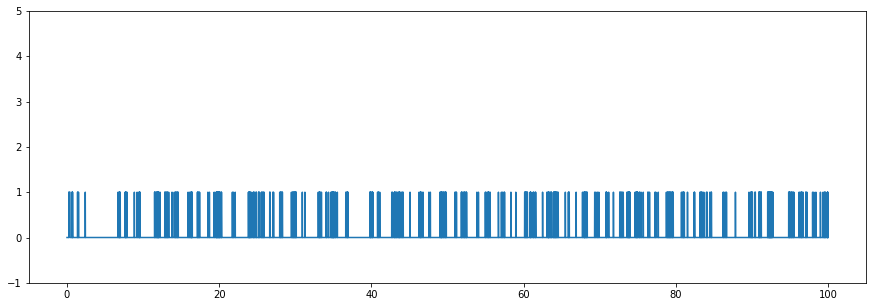

In [46]:
rth=-(B[i]-0.6)
rth[rth<0]=0
Spikes1=Spike_Time_Generater(rth,0.01,5)
bintimes=np.arange(1,len(rth)+0.001)*dt
[binspike,bintimes]=np.histogram(Spikes1,bins=bintimes)

f,ax=plt.subplots(figsize=(15,5))
# plt.plot(bintimes[:-1],binspike)
plt.plot(bintimes,SpikeTrains_Poisson[1])
# plt.xlim(50,60)
plt.ylim(-1,5)

In [16]:
len(bintimes)

9999